In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import os
import time

from smart_home import Load, SmartHome

import matplotlib 
% matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
path = 'Data'

In [3]:
consumption_factor = 2

##### FOR THE PREDICTION, CHOOSE A DATE IN AUGUST 2018!

# Load production and consumption data

In [4]:
weather_hourly = pd.read_csv(os.path.join(path, 'data_hourly.csv'))
weather_hourly['timestamps'] = pd.to_datetime(weather_hourly.timestamps)
weather_hourly.set_index('timestamps', inplace = True)

In [5]:
production_10min = pd.read_csv(os.path.join(path, 'PV_output.csv'), header = None)
production_10min.rename({0 : 'timestamps', 1 : 'power'}, axis = 1, inplace = True)
production_10min['timestamps'] = pd.to_datetime(production_10min.timestamps)
production_10min.set_index('timestamps', inplace = True)
production_10min = production_10min.power / 1000

In [6]:
consumption_10min = pd.read_csv(os.path.join(path, 'baseload_aug_10min.csv'), header = None, nrows = 31*24*6)
consumption_10min.rename({0 : 'timestamps', 1 : 'power'}, axis = 1, inplace = True)
consumption_10min['timestamps'] = pd.to_datetime(consumption_10min.timestamps, format = '%d/%m/%Y %H:%M')
consumption_10min.set_index('timestamps', inplace = True)
consumption_10min['power'] = consumption_10min.power * consumption_factor * 6

In [7]:
consumption_hourly = pd.read_csv(os.path.join(path, 'baseload_aug_hourly.csv'), header = None, nrows = 31*24)
consumption_hourly.rename({0 : 'timestamps', 1 : 'power'}, axis = 1, inplace = True)
consumption_hourly['timestamps'] = pd.to_datetime(consumption_hourly.timestamps, format = '%d/%m/%Y %H:%M')
consumption_hourly.set_index('timestamps', inplace = True)
consumption_hourly['power'] = consumption_hourly.power * consumption_factor

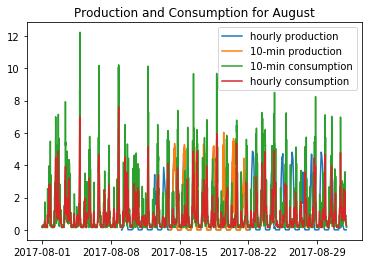

In [8]:
plt.figure()
plt.plot(weather_hourly.power_output_noisy['20170801':'20170831'], label = 'hourly production')
plt.plot(production_10min['20170801':'20170831'], label = '10-min production')
plt.plot(consumption_10min, label = '10-min consumption')
plt.plot(consumption_hourly, label = 'hourly consumption')
plt.title('Production and Consumption for August')
plt.legend()
plt.show()

# Initialize smart home

### Declare variable loads

In [9]:
cleaning_robot = Load(power = 0.4, duration = 3, name = 'cleaning_robot')
washing_machine = Load(power = 1.2, duration = 2, name = 'washing_machine')
variable_loads = (cleaning_robot, washing_machine)

### Declare smart home

/Applications/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


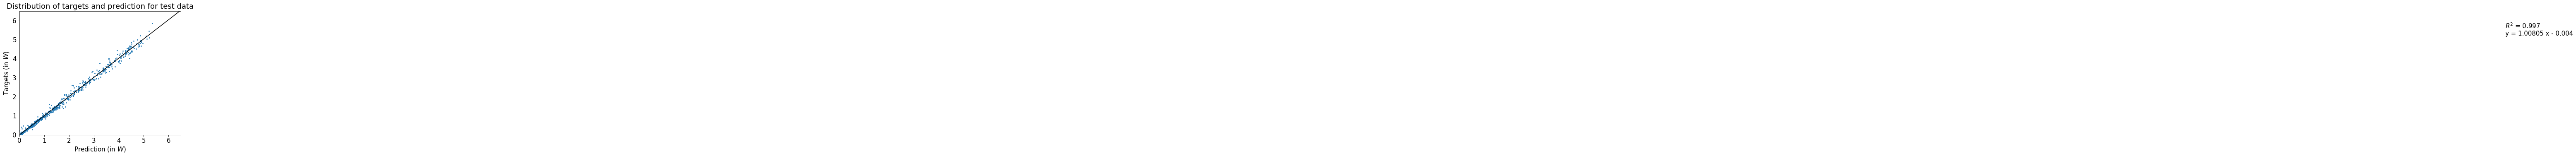

set up and trained weather predictor with data up to  20170731
set up battery with capacity 13.50 and maximum power 5.00
set up variable load optimizer
set up base load


In [10]:
my_home = SmartHome(battery_capacity = 13.5, battery_power = 5, 
                    variable_loads = variable_loads,
                    base_load = consumption_hourly,
                    weather_data = weather_hourly, train_date = '20170731',
                    log_name = os.path.join(path, 'log.csv')
                   )

In [11]:
predict_start = pd.to_datetime('20170814-00')
predict_end = pd.to_datetime('20170821-23')

In [12]:
curr_time = pd.to_datetime('20170814-20')

## Set up evaluation

# RUN SMART HOME IN REAL TIME

In [13]:
for curr_time in pd.date_range('20170815-05', '20170815-23', freq = 'h'):
    print(curr_time)
    output = my_home.update(curr_time)
    print('\n')
    time.sleep(0.1)
    
    # evaluate(output)

2017-08-15 05:00:00
resetted current token
current PV production: 0.31kWh
current base consumption: 0.58kWh
current variable consumption: 0.00kWh
current battery usage: 0.00kWh
total self consumption: 0.31kWh
new token value for today: 0.31
predicted all future loads


2017-08-15 06:00:00
current PV production: 1.17kWh
current base consumption: 0.80kWh
current variable consumption: 0.40kWh
current battery usage: 0.00kWh
total self consumption: 1.17kWh
new token value for today: 1.47
predicted all future loads


2017-08-15 07:00:00
current PV production: 2.14kWh
current base consumption: 0.40kWh
current variable consumption: 1.60kWh
charge battery; new battery state of charge: 0.01
current battery usage: 0.14kWh
total self consumption: 2.14kWh
new token value for today: 3.61
predicted all future loads


2017-08-15 08:00:00
current PV production: 3.11kWh
current base consumption: 0.50kWh
current variable consumption: 1.60kWh
charge battery; new battery state of charge: 0.09
current batte

# Evaluation

## Evaluate past data to get token

In [35]:
log_hist = pd.read_csv(os.path.join(path, 'log_history.csv'))

In [37]:
log_hist['timestamp'] = pd.to_datetime(log_hist.timestamp, format = '%d/%m/%Y %H:%M')
log_hist.set_index('timestamp', inplace = True)

In [38]:
daily_frame = log_hist.groupby(log_hist.index.date).sum()

In [39]:
token_frame = daily_frame.drop(['PV_production', 'load_consumption', 'battery_consumption'], axis = 1)
token_frame.rename({'self_consumption' : 'token_value'}, inplace = True, axis = 1)

In [42]:
token_frame.to_csv(os.path.join(path, 'tokens.csv'))

## Spielwiese